# Machine Learning for Complete Intersection Calabi-Yau Manifolds

We then separately consider another ML approach to predict the **Hodge numbers** from the configuration matrix of CICY 3-folds: we implement **neural networks** (NN) in order to improve previous predictions using different kinds of architectures. In particular we will use **convolutional** NN (CNN) to process the configuration matrix using kernel convolutions (as if we were considering a "computer vision" task). We try different architectures such as a CNN with only convolutional hidden layers, as opposed to a CNN which uses a **fully connected** (FC) network to process the output.

We will use the [Tensorflow](https://www.tensorflow.org/) backend to implement NNs on the GPU, using the [Keras](https://www.tensorflow.org/api_docs/python/tf/keras) high level API.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

# print info on GPU
!nvidia-smi

Current OS:                  Linux (kernel release: 5.6.6-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       3451 MHz (max: 3800 MHz)
Available RAM memory:        10516 MB (tot: 15758 MB)
Mon Apr 27 00:10:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   42C    P0    N/A /  N/A |      5MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                    

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [2]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Tensorflow version: {}'         .format(tf.__version__))
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


## Session Preparation

in order to save the results of the analysis, we define where to store images, log files and models:

In [3]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs

DB_NAME = 'cicy3o' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '_analysis.h5' #------------------------------ full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)

We also create a log file to store debug and related information:

In [4]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '_nn.log'
                       )
log = create_logfile(path_to_log,
                     name=DB_NAME + '_nn',
                     level=logging.DEBUG
                    )

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

Rotating existing logs...


2020-04-27 00:10:38,781: INFO ==> New logging session started. Log is at ./log/original/cicy3o_nn.log.


We finally set the _memory growth_ property of the GPU in order to avoid overflowing its RAM memory:

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------------------------------- list of physical GPUs

if gpus: #----------------------------------------------------------------------------------------- set memory growth only if GPU is active
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------------------------------- set memory growth
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') #------------------------ list of logical devices
        print('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus),
                                                                         len(logical_gpus)
                                                                        )
             )
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs in the setup!')

GPU setup: 1 physical GPUs, 1 logical GPUs.


## Loading the Dataset

We first load the dataset we built during the preanalysis.

In [6]:
import pandas as pd

# load the dataset
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    log.debug('Database loaded.')
    log.info('Shape is {:d} rows x {:d} columns.'.format(df.shape[0], df.shape[1]))
else:
    log.error('Cannot load database from {}!'.format(DB_PATH))

2020-04-27 00:10:39,177: DEBUG ==> Database loaded.
2020-04-27 00:10:39,178: INFO ==> Shape is 7851 rows x 7 columns.


We print the `dtypes` and the name of the keys inside the dataframe as a reference:

In [7]:
df.dtypes

h11            int16
h21            int16
num_cp          int8
dim_cp        object
dim_h0_amb    object
matrix        object
pca           object
dtype: object

## Dense Format Extraction

We now extract the matrix from the available features and the labels. Notice that in this case we do not flatten the output as it will be processed by _Conv2D_ layers in _Keras_: we reshape it as if it was a black and white image, that is we take each matrix of shape (width, height) and output a matrix of shape (width, height, 1):

In [8]:
from mltools.libtransformer import ExtractTensor

# extract the labels
h11    = df['h11'].values
h21    = df['h21'].values

# we also extract num_cp for the plots (not for training)
num_cp = np.array(ExtractTensor(flatten=True).fit_transform(df['num_cp']))

# extract the tensor features
matrix = np.array(ExtractTensor(flatten=False).fit_transform(df['matrix'])) #-------- old shape is (batch, width, height)
matrix = np.reshape(matrix, (-1, np.shape(matrix)[1], np.shape(matrix)[2], 1)) #----- new shape is (batch, width, height, 1)

log.debug('Matrix shape: {}'.format(np.shape(matrix)))

2020-04-27 00:10:39,923: DEBUG ==> Matrix shape: (7851, 12, 15, 1)


## Training and Validation Strategy

We now define the validation strategy and split the dataset into training, validation and test sets.

We will take out 10% of the dataset to be our **test set**. For the remaining 90% of the dataset, we will use **holdout validation** with $\frac{1}{9}$ of the training samples as validation (effectively we use 80% of the total set for training and 10% as validation).

In [9]:
from sklearn.model_selection import train_test_split

# divide into training and test sets
matrix_train, matrix_test, \
num_cp_train, num_cp_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(matrix, num_cp, h11, h21, test_size=0.1, shuffle=False)

# keep a holdout validation set
matrix_train, matrix_val, \
num_cp_train, num_cp_val, \
h11_train, h11_val, \
h21_train, h21_val = train_test_split(matrix_train, num_cp_train, h11_train, h21_train, test_size=1.0/9.0, shuffle=False)

log.debug('Train set size: {:d}'.format(np.shape(matrix_train)[0]))
log.debug('Validation set size: {:d}'.format(np.shape(matrix_val)[0]))
log.debug('Test set size: {:d}'.format(np.shape(matrix_test)[0]))

2020-04-27 00:10:39,946: DEBUG ==> Train set size: 6280
2020-04-27 00:10:39,947: DEBUG ==> Validation set size: 785
2020-04-27 00:10:39,947: DEBUG ==> Test set size: 786


We also provide a way to visualise the predictions by comparing the predictions as function of a (scalar) base feature (e.g.: `num_cp`) with respect to the ground truth:

In [10]:
def get_counts(base_feature, label):
    '''
    Returns unique values and counts of the label as a function of the base_feature.
    
    Required arguments:
        base_feature: the feature considered as base for the comparison,
        label:        the label we are interested in comparing.
    
    Yields:
        [ unique value of base_feature, unique value of label, count ].
    '''
    
    for n in np.sort(np.unique(base_feature)):
        uniques, counts = np.unique(label[np.argwhere(base_feature == n)[:,0]], return_counts=True)
        
        for u, c in np.c_[uniques, counts]:
            yield [n, u, c]

Notice that the use of `num_cp` will only be necessary to show in a simple way how well the algorithm can predict $h_{11}$ and $h_{21}$. `num_cp` will be taken as a representative of the matrices in the test set and $h_{11}$ and $h_{21}$ will be shown in a 2D plot.

## Feature Rescaling

Before proceeding we rescale the input matrices to have entries in $\left[ 0, 1 \right]$: we divide each entry of each matrix by the range of variation of its entries (since they are all positive, we divide by the maximum) in the **training** set. We then apply the **same scaling** to validation and test sets.

In [11]:
# compute the scale factor
scale_factor = np.max(matrix_train) - np.min(matrix_train)

# rescale the sets
matrix_train = matrix_train / scale_factor
matrix_val   = matrix_val   / scale_factor
matrix_test  = matrix_test  / scale_factor

# define the shape of the tensors (batch axis excluded) since we will use it later one
input_shape  = np.shape(matrix_train)[1:]

## Input Visualisation

Using _matplotlib_ we can try to visualise a few samples of the training set to better understand what kind of input we are dealing with and come up with a good strategy for the architecture of the neural network.

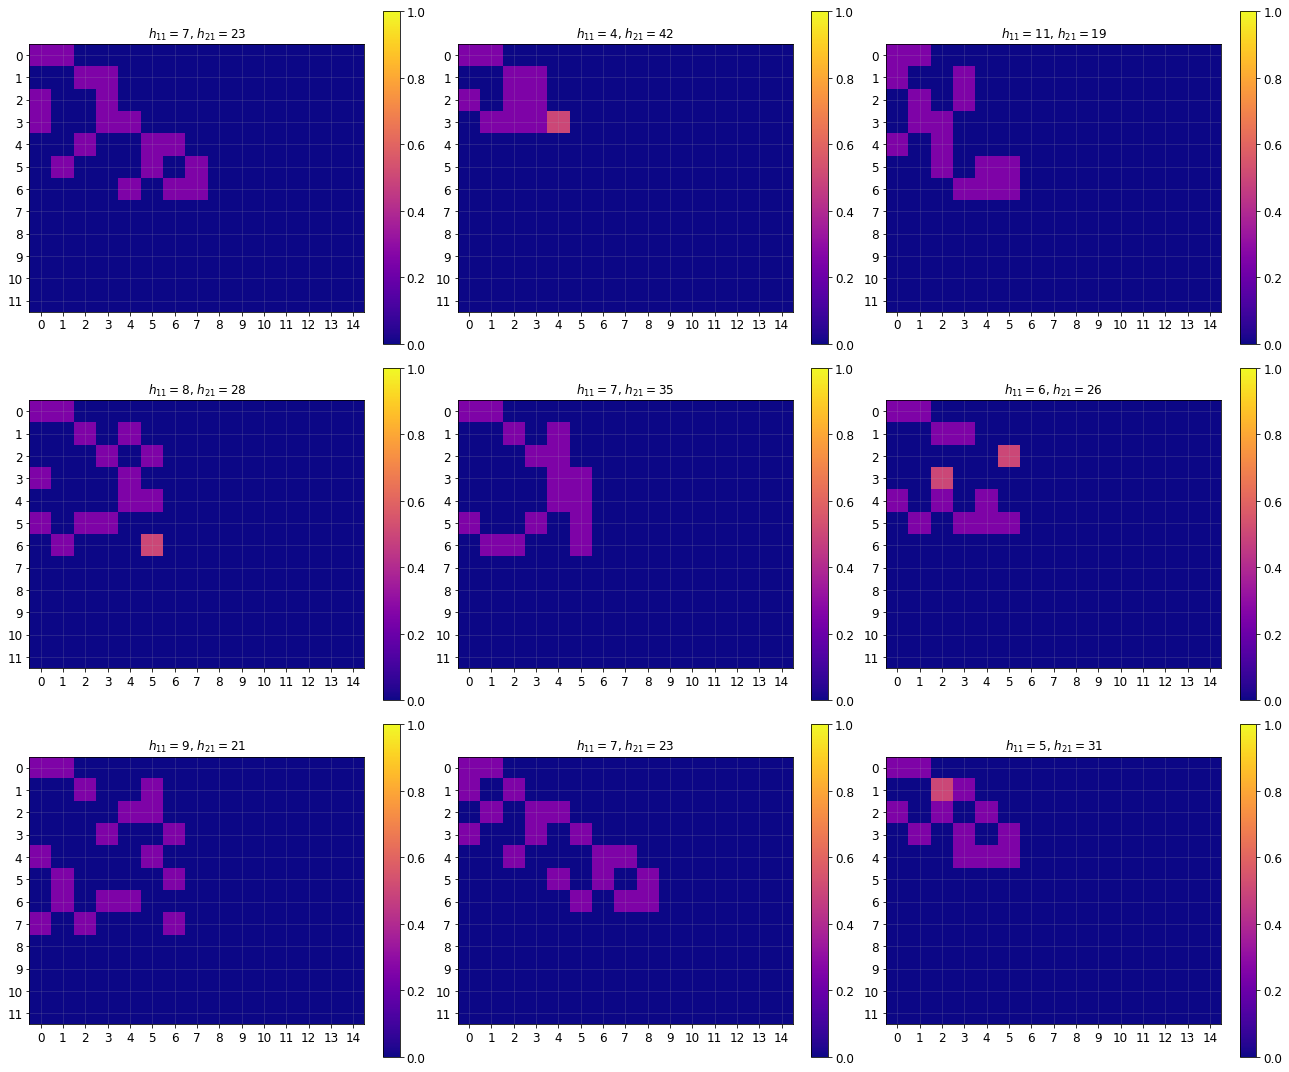

2020-04-27 00:10:42,410: DEBUG ==> Plot saved in ./img/original/nn_input_visualisation.pdf.


In [12]:
from mltools.libplot import Plot

# choose 4 random indices
rnd = np.random.randint(low=0, high=np.shape(matrix_train)[0], size=(9,))

# decide the colour map
cmap = 'plasma'

# plot the matrices
plot = Plot(rows=3, columns=3)

plot.matrix(data=np.reshape(matrix_train[rnd[0]], (np.shape(matrix_train[rnd[0]])[0], np.shape(matrix_train[rnd[0]])[1])),
            axis=(0,0),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[0]], '{21}', h21_train[rnd[0]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[1]], (np.shape(matrix_train[rnd[1]])[0], np.shape(matrix_train[rnd[1]])[1])),
            axis=(0,1),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[1]], '{21}', h21_train[rnd[1]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[2]], (np.shape(matrix_train[rnd[2]])[0], np.shape(matrix_train[rnd[2]])[1])),
            axis=(0,2),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[2]], '{21}', h21_train[rnd[2]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[3]], (np.shape(matrix_train[rnd[3]])[0], np.shape(matrix_train[rnd[3]])[1])),
            axis=(1,0),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[3]], '{21}', h21_train[rnd[3]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[4]], (np.shape(matrix_train[rnd[4]])[0], np.shape(matrix_train[rnd[4]])[1])),
            axis=(1,1),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[4]], '{21}', h21_train[rnd[4]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[5]], (np.shape(matrix_train[rnd[5]])[0], np.shape(matrix_train[rnd[5]])[1])),
            axis=(1,2),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[5]], '{21}', h21_train[rnd[5]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[6]], (np.shape(matrix_train[rnd[6]])[0], np.shape(matrix_train[rnd[6]])[1])),
            axis=(2,0),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[6]], '{21}', h21_train[rnd[6]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[7]], (np.shape(matrix_train[rnd[7]])[0], np.shape(matrix_train[rnd[7]])[1])),
            axis=(2,1),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[7]], '{21}', h21_train[rnd[7]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )
plot.matrix(data=np.reshape(matrix_train[rnd[8]], (np.shape(matrix_train[rnd[8]])[0], np.shape(matrix_train[rnd[8]])[1])),
            axis=(2,2),
            title='$h_{} = {:d}$, $h_{} = {:d}$'.format('{11}', h11_train[rnd[8]], '{21}', h21_train[rnd[8]]),
            cmap=cmap,
            vmin=0.0,
            vmax=1.0
           )


plot.save_and_close(path.join(IMG_PATH, 'nn_input_visualisation'))
log.debug('Plot saved in {}.'.format(path.join(IMG_PATH, 'nn_input_visualisation.pdf')))

## Architecture Building

We then move to the problem of building the correct architecture. We will first implement a function which will allow us to build different models using similar structure blocks: the idea is to first process the images through convolutional layers, then add a FC network at the end (we will also add dropout and normalization layers).

In [13]:
from tensorflow.keras.models       import Model
from tensorflow.keras.layers       import Input, Conv2D, Dense, LeakyReLU, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers   import Adam

def cnn_model(input_shape,
              model_name='cnn_model',
              learning_rate=0.01,
              conv_layers=[32],
              conv_paddings=['same'],
              conv_kernels=[(2,2)],
              conv_alpha=0.0,
              fc_layers=[],
              fc_alpha=0.0,
              dropout=0.2,
              normalization=0.99,
              last_relu=True,
              out_name='output',
              l1_reg=0.0,
              l2_reg=0.0
             ):
    '''
    Build a CNN model.
    
    Required arguments:
        input_size:    the size of the input tensor.
        
    Optional arguments:
        model_name:    the name of the model,
        learning_rate: the learning rate of the gradient descent,
        conv_layers:   a list-like object with the no. of filters for each hiddend convolution layer,
        conv_paddings: a list-like object with the corresponding padding for each layer,
        conv_kernels:  a list-like object with the kernel size of each layer,
        conv_alpha:    the slope of the LeakyReLU activation (ReLU if 0.0) of the convolution layers,
        fc_layers:     a list-like object with the no. of units for each hidden dense layer,
        fc_alpha:      the slope of the LeakyReLU activation (ReLU if 0.0) of the FC network,
        dropout:       the dropout rate (do not use dropout if <= 0.0),
        normalization: the momentum of the batch normalization (do not use normalization if <= 0.0),
        last_relu:     whether to use ReLU activation in the output layer (force positive output),
        out_name:      the name of the output layer,
        l1_reg:        the L1 kernel regularization factor,
        l2_reg:        the L2 kernel regularization factor.
        
    Returns:
        the compiled model.
    '''
    
    # define the regularizer
    regularizer = l1_l2(l1=l1_reg, l2=l2_reg) #--------------------------------------------- regularizer
 
    # build the model
    I = Input(shape=input_shape, name='input') #-------------------------------------------- input layer
    x = I
    
    # build convolutional layers
    for n in range(np.shape(conv_layers)[0]): #--------------------------------------------- loop through the conv. layers
        x = Conv2D(filters=conv_layers[n],
                   kernel_size=conv_kernels[n],
                   padding=conv_paddings[n],
                   kernel_regularizer=regularizer,
                   name='conv2d_' + str(n)
                  )(x) #-------------------------------------------------------------------- add conv. layer
        x = LeakyReLU(alpha=conv_alpha,
                      name='conv2d_' + str(n) + '_activation'
                     )(x) #----------------------------------------------------------------- add activation
        
        if normalization > 0.0:
            x = BatchNormalization(momentum=normalization,
                                   name='conv2d_' + str(n) + '_normalization'
                                  )(x) #---------------------------------------------------- add batch normalization (if requested)
        
    # add dropout
    if dropout > 0.0:
        x = Dropout(rate=dropout,
                    name='dropout'
                   )(x) #------------------------------------------------------------------- add dropout (if requested)
        
    # flatten the output
    x = Flatten(name='flatten')(x) #-------------------------------------------------------- flatten the output
    
    # build FC network
    for n in range(np.shape(fc_layers)[0]):
        x = Dense(units=fc_layers[n],
                  kernel_regularizer=regularizer,
                  name='fc_' + str(n)
                 )(x) #--------------------------------------------------------------------- add dense layers
        x = LeakyReLU(alpha=fc_alpha,
                      name='fc_' + str(n) + '_activation'
                     )(x) #----------------------------------------------------------------- add activation
        
        if normalization > 0.0:
            x = BatchNormalization(momentum=normalization,
                                   name='fc_' + str(n) + '_normalization'
                                  )(x) #---------------------------------------------------- add batch normalization (if requested)
        
    if last_relu: #------------------------------------------------------------------------- output layer
        F = Dense(1, activation='relu', name=out_name)(x)
    else:
        F = Dense(1, name=out_name)(x)
    
    # define the model
    model = Model(inputs=I, outputs=F, name=model_name)
    
    # compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error']
                 )
    
    # return the compiled model
    return model

We will consider different models and train them all and then compare and discuss the results. The models we implement will compare these peculiarities:

- small vs. large kernels,
- FC network vs. no FC network,
- padding vs. no padding.

The idea behind the _small kernels_ is to have a small no. of operations and to be fairly quick to train (smaller kernels will probably need more layers, though), while larger kernels usually improve the results in the field of [semantic segmentation](https://arxiv.org/abs/1703.02719) and may be worth the try (we will also need less hidden layers). The fully connected layers can then help in processing the output, however the no. of parameters will increase substantially since they are dense layers (one of the goals will be to build the **smallest NN**). The padding operation will instead guide the convolution operation by reducing the output (and input) size of each layer (when using padding we could also add a FC network to a very small convolutional layer and keep the no. of parameters small).

We will then compare the results with [Bull et al](https://arxiv.org/abs/1806.03121).

In [14]:
from tensorflow.keras.backend   import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def cnn_fit(model,
            X,
            y,
            X_val,
            y_val,
            batch_size=32,
            epochs=100,
            early_stopping=10,
            reduce_lr=5,
            verbose=0
           ):
    '''
    Fit the model.
    
    Required arguments:
        model:          the model to fit,
        X:              the training features,
        y:              the training labels,
        X_val:          the validation features,
        y_val:          the validation labels.
        
    Optional arguments:
        batch_size:     the size of the batch used in forward pass,
        epochs:         the number of epochs,
        early_stopping: patience of early stopping,
        reduce_lr:      patience to reduce learning rate,
        verbose:        verbosity level (debug)
    
    Returns:
        the fitted model, the history of the model.
    '''
    
    # clear the TF graph
    clear_session()
    
    # define callbacks
    callbacks = [EarlyStopping(monitor='val_mean_squared_error',
                               patience=early_stopping,
                               verbose=verbose
                              ),
                 ReduceLROnPlateau(monitor='val_mean_squared_error',
                                   factor=0.3,
                                   patience=reduce_lr,
                                   verbose=verbose
                                  ),
                 ModelCheckpoint(filepath=path.join(MOD_PATH, model.name + '.h5'),
                                 monitor='val_mean_squared_error',
                                 verbose=verbose,
                                 save_best_only=True,
                                 save_format='h5'
                                )
                ]
    
    # fit the model
    history = model.fit(x=X,
                        y=y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=(X_val, y_val)
                       )
    
    # return the fitted model and its history
    return model, history

## Analysis for $h_{11}$

We now have the instruments to proceed with the analysis, starting with the prediction of $h_{11}$.

Model: "h11_deep_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 12, 15, 1)]       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 15, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 180)               0         
_________________________________________________________________
fc_0 (Dense)                 (None, 1)                 181       
_________________________________________________________________
fc_0_activation (LeakyReLU)  (None, 1)                 0         
_________________________________________________________________
fc_0_normalization (BatchNor (None, 1)                 4         
_________________________________________________________________
output (Dense)               (None, 1)                

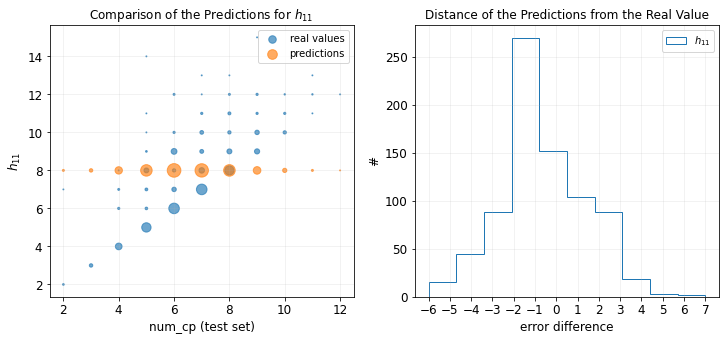

In [21]:
import json

from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils  import plot_model
from mltools.libscore        import Score

model = cnn_model(input_shape=input_shape,
                  model_name='h11_deep_cnn',
                  learning_rate=0.01,
                  conv_layers=[],
                  conv_paddings=[],
                  conv_kernels=[],
                  conv_alpha=0.0,
                  fc_layers=[1],
                  fc_alpha=0.0,
                  dropout=0.4,
                  normalization=0.99,
                  last_relu=True,
                  l1_reg=1.0e-5,
                  l2_reg=1.0e-5
                 )

model.summary()

model, history = cnn_fit(model=model,
                         X=matrix_train, y=h11_train,
                         X_val=matrix_val, y_val=h11_val,
                         batch_size=32,
                         epochs=10,
                         early_stopping=100,
                         reduce_lr=40,
                         verbose=1
                        )

preds_val_h11  = np.reshape(model.predict(matrix_val), (-1,))
preds_test_h11 = np.reshape(model.predict(matrix_test), (-1,))

rounding=np.rint
score_val_h11  = Score(y_true=h11_val, y_pred=preds_val_h11, rounding=rounding)
score_test_h11 = Score(y_true=h11_test, y_pred=preds_test_h11, rounding=rounding)

print('Name of the model: {}'.format(model.name))
print('Number of parameters: {:d}'.format(model.count_params()))
print('Accuracy on the validation set: {:.3f}%'.format(score_val_h11.accuracy()*100))
print('Accuracy on the test set: {:.3f}%'.format(score_test_h11.accuracy()*100))

plot = Plot(rows=1, columns=2)

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(preds_test_h11)))).T,
               axis=0,
               title='Comparison of the Predictions for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.hist2D(score_test_h11.error(),
            axis=1,
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )